Blatently stolen from.
https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split 
from sklearn import metrics   #Additional scklearn functions
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier

%matplotlib inline

In [28]:
pd.set_option("display.max_columns",101)

In [29]:
filename = 'KaggleV2-May-2016_join_with_weather_may5_1338.csv'
dd = pd.read_csv(filename, encoding='latin')

# lb_Encoder = LabelEncoder()
# dd['Neighbourhood_category'] = lb_Encoder.fit_transform(dd['Neighbourhood'])
# dd['Gender_category'] = lb_Encoder.fit_transform(dd['Gender'])
# dd['no_show'] = dd['No-show'] == 'Yes'



# dd['ScheduledDay'] = dd.ScheduledDay.apply(lambda x: x.strip('Z')).apply(lambda x: x.replace('T', ' '))
# dd['ScheduledDay'] = pd.to_datetime(dd['ScheduledDay'])
# dd['AppointmentDay'] = dd.AppointmentDay.apply(lambda x: x.strip('Z')).apply(lambda x: x.replace('T', ' '))
# dd['AppointmentDay'] = pd.to_datetime(dd['AppointmentDay'])

# dd['time_d'] = dd['AppointmentDay'] - dd['ScheduledDay']
# dd['time_d_total_seconds'] = dd.time_d.apply(lambda x: x.total_seconds())
# dd['time_d_total_days'] = dd['time_d_total_seconds']/(24.0*60.0*60.0)
# dd['time_d_total_days'] = dd['time_d_total_days'].astype(int)

# dd['a_day_of_week'] = dd.AppointmentDay.apply(lambda x: x.dayofweek)
# dd['s_day_of_week'] = dd.ScheduledDay.apply(lambda x: x.dayofweek)

In [30]:
dd.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,time_d,time_d_total_seconds,a_day_of_week,s_day_of_week,Neighbourhood_category,Gender_category,no_show,scheduled_hour,time_d_total_days,minpressurem,minhumidity,maxtempi,mintempi,maxpressurei,precipm,mindewptm,meanwindspdm,meandewpti,mintempm,maxhumidity,maxpressurem,meantempm,precipi,meanwdire,maxwspdi,humidity,minpressurei,maxdewpti,maxtempm,mindewpti,meandewptm,meanwindspdi,meanwdird,maxwspdm,maxdewptm,meantempi,date_tzname,date_mon,date_hour,date_min,date_year,date_pretty,date_mday,datetime
0,2.987250e+13,5642903,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No,-1 days +05:21:52.000000000,-67088.0,4,4,39,0,False,18,0,1015.1,77.0,74.1,70.9,30.09,0.3,18.0,14.7,66.2,21.6,87.0,1018.8,22.5,0.01,SSW,24.0,81.0,29.98,68.5,23.4,64.4,19.0,9.1,NaN,38.6,20.3,72.5,America/Sao_Paulo,4.0,0.0,0.0,2016.0,"April 29, 2016",29.0,2016-04-29
1,5.589980e+14,5642503,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No,-1 days +07:51:33.000000000,-58107.0,4,4,39,1,False,16,0,1015.1,77.0,74.1,70.9,30.09,0.3,18.0,14.7,66.2,21.6,87.0,1018.8,22.5,0.01,SSW,24.0,81.0,29.98,68.5,23.4,64.4,19.0,9.1,NaN,38.6,20.3,72.5,America/Sao_Paulo,4.0,0.0,0.0,2016.0,"April 29, 2016",29.0,2016-04-29
2,4.262960e+12,5642549,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No,-1 days +07:40:56.000000000,-58744.0,4,4,45,0,False,16,0,1015.1,77.0,74.1,70.9,30.09,0.3,18.0,14.7,66.2,21.6,87.0,1018.8,22.5,0.01,SSW,24.0,81.0,29.98,68.5,23.4,64.4,19.0,9.1,NaN,38.6,20.3,72.5,America/Sao_Paulo,4.0,0.0,0.0,2016.0,"April 29, 2016",29.0,2016-04-29
3,8.679510e+11,5642828,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,-1 days +06:30:29.000000000,-62971.0,4,4,54,0,False,17,0,1015.1,77.0,74.1,70.9,30.09,0.3,18.0,14.7,66.2,21.6,87.0,1018.8,22.5,0.01,SSW,24.0,81.0,29.98,68.5,23.4,64.4,19.0,9.1,NaN,38.6,20.3,72.5,America/Sao_Paulo,4.0,0.0,0.0,2016.0,"April 29, 2016",29.0,2016-04-29
4,8.841190e+12,5642494,F,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No,-1 days +07:52:37.000000000,-58043.0,4,4,39,0,False,16,0,1015.1,77.0,74.1,70.9,30.09,0.3,18.0,14.7,66.2,21.6,87.0,1018.8,22.5,0.01,SSW,24.0,81.0,29.98,68.5,23.4,64.4,19.0,9.1,NaN,38.6,20.3,72.5,America/Sao_Paulo,4.0,0.0,0.0,2016.0,"April 29, 2016",29.0,2016-04-29


In [31]:
def modelfit(alg, dtrain, predictors, output, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[output])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, dtrain[predictors], dtrain[output], cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print("Model Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain[output].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[output], dtrain_predprob))
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        plt.show()

In [32]:
def plot_roc(classifier, data, predictors, output):
    X = data.as_matrix(columns=predictors)
    y = data[output]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)  #can use a smaller test size because decent data set size

    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)
    y_proba = classifier.predict_proba(X_test)
    
    misclassified_points = (y_test != y_pred).sum()
    accuracy = (X_test.shape[0] - float(misclassified_points)) / X_test.shape[0]*100
    fpr, tpr, _ = roc_curve(y_test, y_proba[:,1])
    auc = roc_auc_score(y_test, y_proba[:,1])
    print("Accuracy = ", accuracy)
    print("AUC = ", auc)

    plt.clf()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.show()

In [33]:
#Choose all predictors except target & IDcols
feature_set  =['Age', 'SMS_received', 'Neighbourhood_category' ,'Scholarship', 'Hipertension', 'Diabetes', 'a_day_of_week', 'Gender_category', 'time_d_total_days']

feature_set += ['maxtempi','precipi','maxwspdi','maxpressurei']

In [34]:
feature_set

['Age',
 'SMS_received',
 'Neighbourhood_category',
 'Scholarship',
 'Hipertension',
 'Diabetes',
 'a_day_of_week',
 'Gender_category',
 'time_d_total_days',
 'maxtempi',
 'precipi',
 'maxwspdi',
 'maxpressurei']

In [35]:
#some of the weather data is missing

dd = dd[feature_set + ['no_show']].dropna()

Model Report
Accuracy : 0.7976
AUC Score (Train): 0.732152
CV Score : Mean - 0.7059861 | Std - 0.0196457 | Min - 0.6718719 | Max - 0.7259707


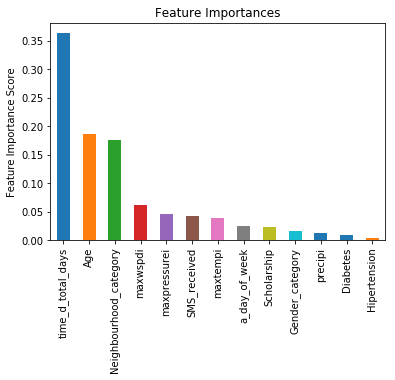

In [36]:
gbm0 = GradientBoostingClassifier(random_state=10)
modelfit(gbm0, dd, feature_set, 'no_show')

In [37]:
param_test1 = {'n_estimators':range(20,81,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
print(gsearch1.fit(dd[feature_set],dd['no_show']))
print("CV_results ", gsearch1.cv_results_)
print("Best params ", gsearch1.best_params_)
print("Best score ", gsearch1.best_score_)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=50, min_samples_split=500,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'n_estimators': range(20, 81, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)
CV_results  {'split3_test_score': array([0.70653043, 0.70677389, 0.7024646 , 0.70047962, 0.69955495,
       0.69542457, 0.69309338]), 'split1_test_score': array([0.7243952 , 0.72482054, 0.72559398, 0.72589547, 0.72482673,
       0.72408979, 0.72306699]), 'spli

In [38]:
param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
print(gsearch2.fit(dd[feature_set],dd['no_show']))
print("CV_results ", gsearch2.cv_results_)
print("Best params ", gsearch2.best_params_)
print("Best score ", gsearch2.best_score_)


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=60,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'min_samples_split': range(200, 1001, 200), 'max_depth': range(5, 16, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)
CV_results  {'split1_test_score': array([0.72590543, 0.72584213, 0.72616812, 0.72543261, 0.72560944,
       0.72331811, 0.72405876, 0.72233243, 0.72425915, 0.7254225 ,
       0.72118465, 0.72179817, 0.72043311, 0.72349647, 0.

In [39]:
param_test3 = {'min_samples_split':range(1000,2100,200), 'min_samples_leaf':range(30,71,10)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,max_depth=9,max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
print(gsearch3.fit(dd[feature_set],dd['no_show']))
print("CV_results ", gsearch3.cv_results_)
print("Best params ", gsearch3.best_params_)
print("Best score ", gsearch3.best_score_)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=9,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=60,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'min_samples_split': range(1000, 2100, 200), 'min_samples_leaf': range(30, 71, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)
CV_results  {'split1_test_score': array([0.7218784 , 0.72434164, 0.72392935, 0.7252495 , 0.7266238 ,
       0.72575291, 0.72346152, 0.72431453, 0.72379088, 0.72433429,
       0.72333347, 0.7240657 , 0.72217705, 0.72

In [40]:
param_test4 = {'max_features':range(2,8,1)}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,max_depth=9, min_samples_split=1200, min_samples_leaf=60, subsample=0.8, random_state=10),
param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
print(gsearch4.fit(dd[feature_set],dd['no_show']))
print("CV_results ", gsearch4.cv_results_)
print("Best params ", gsearch4.best_params_)
print("Best score ", gsearch4.best_score_)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=9,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=60, min_samples_split=1200,
              min_weight_fraction_leaf=0.0, n_estimators=60,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'max_features': range(2, 8)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='roc_auc', verbose=0)
CV_results  {'split3_test_score': array([0.70641999, 0.69875385, 0.69926244, 0.69519497, 0.69491245,
       0.69299859]), 'split1_test_score': array([0.72365461, 0.72432922, 0.72348579, 0.72479006, 0.7240572 ,
       0.7247635 ]), 'split0_train_score': array([0.75258648, 0.7

In [41]:
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,max_depth=9,min_samples_split=1200, min_samples_leaf=60, subsample=0.8, random_state=10,max_features=7),
param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
print(gsearch5.fit(dd[feature_set],dd['no_show']))
print("CV_results ", gsearch5.cv_results_)
print("Best params ", gsearch5.best_params_)
print("Best score ", gsearch5.best_score_)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=9,
              max_features=7, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=60, min_samples_split=1200,
              min_weight_fraction_leaf=0.0, n_estimators=60,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'subsample': [0.6, 0.7, 0.75, 0.8, 0.85, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)
CV_results  {'split3_test_score': array([0.69570455, 0.69407786, 0.69400862, 0.69299859, 0.69129239,
       0.69486519]), 'split1_test_score': array([0.72529023, 0.72413357, 0.7213939 , 0.7247635 , 0.72246199,
       0.72362416]), 'split0_train_score': 

5 models give us...
min_samples_leaf: 70  
min_samples_split': 2000 ...or ... min_samples_split: 200  ** SO i'll go for 1100  
max_depth: 5  
n_estimators: 20  
subsample: 0.75 
max_features: 2 ****** REALLY!... ignore that

Model Report
Accuracy : 0.7972
AUC Score (Train): 0.730428
CV Score : Mean - 0.7091746 | Std - 0.01759266 | Min - 0.6772009 | Max - 0.7260278


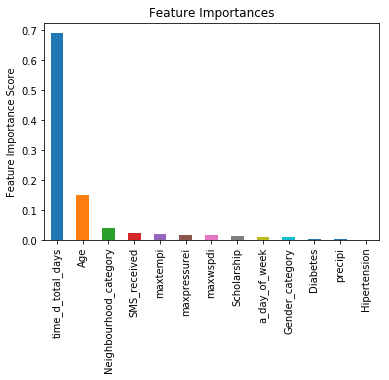

Accuracy =  79.47294117647058
AUC =  0.7268264245863081


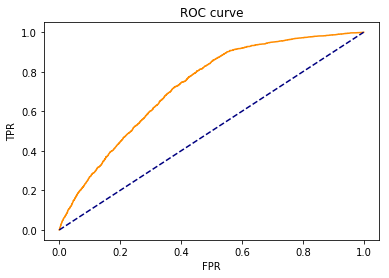

In [42]:
gbm_tuned_1 = GradientBoostingClassifier(n_estimators=20, max_depth=5,min_samples_leaf=70, subsample=0.75,min_samples_split=1100)
modelfit(gbm_tuned_1, dd, feature_set, 'no_show')
plot_roc(gbm_tuned_1, dd, feature_set, 'no_show')
